In [98]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
import glob
import pandas as pd
import os
import seaborn as sns

from tqdm import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
from collections import defaultdict
import pickle
import re
import json
from pathlib import Path
import scipy.stats
import time

from open_spiel.python.algorithms.exploitability import nash_conv, best_response
from open_spiel.python.examples.ubc_plotting_utils import *
from open_spiel.python.examples.ubc_sample_game_tree import sample_game_tree, flatten_trees, flatten_tree
from open_spiel.python.examples.ubc_clusters import projectPCA, fitGMM
from open_spiel.python.examples.ubc_utils import *
import open_spiel.python.examples.ubc_dispatch as dispatch

from auctions.webutils import *

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

from open_spiel.python.examples.ubc_cma import *

output_notebook()
from open_spiel.python.games.clock_auction_base import InformationPolicy, ActivityPolicy, UndersellPolicy, TiebreakingPolicy
from open_spiel.python.algorithms.exploitability import nash_conv, best_response
from open_spiel.python.examples.ubc_decorators import TakeSingleActionDecorator, TremblingAgentDecorator, ModalAgentDecorator

Loading BokehJS ...

In [5]:
list(Experiment.objects.all())[-3:]

[<Experiment: oct12_external_heuristics_v2>,
 <Experiment: oct12_external_heuristics_v3>,
 <Experiment: oct13_external_heuristics_v1>]

In [6]:
# load runs from experiments
experiments = []
experiments += ['oct12_external_heuristics_v3']

runs = []
for experiment in experiments:
    runs += Experiment.objects.get(name=experiment).equilibriumsolverrun_set.all()
print(f"Found {len(runs)} runs")

Found 600 runs


# Analyze runs

In [7]:
records = []
for run in tqdm(runs):    
    game = run.game.load_as_spiel()
    record = {
        'run_name': run.name,
        'game_name': run.game.name, 
        'seed': run.config.get('seed'), 
        'config': run.get_config_name(),
        'alg': get_algorithm_from_run(run),
    }
    
    record.update(get_game_info(game, run.game))  
    
    record['no_error'] = False
    records.append(record) # Put it here so you see the False's in the display
        
    try:
        game, final_checkpoint, policy = get_results(run, load_policy=False)
    except Exception as e:
        print(f"Skipping run {run.name} because of error {e}")
        continue
    
    try:
        
        record['t'] = final_checkpoint.t
        record['walltime'] = run.walltime(),
        evaluation = final_checkpoint.get_modal_eval()
        
        record['nash_conv'] = evaluation.nash_conv
        record['rewards'] = evaluation.mean_rewards
        record['nash_conv_frac'] = evaluation.nash_conv / sum(evaluation.mean_rewards) if not pd.isnull(evaluation.nash_conv) else np.nan
        record['heuristic_conv'] = evaluation.heuristic_conv
        record['heuristic_conv_frac'] = evaluation.heuristic_conv / sum(evaluation.mean_rewards) if not pd.isnull(evaluation.heuristic_conv) else np.nan

        for i in range(game.num_players()):
            record[f'rewards_{i}'] = evaluation.mean_rewards[i]
            record[f'nc_player_improvements_{i}'] = evaluation.nash_conv_player_improvements[i] if not pd.isnull(evaluation.nash_conv) else np.nan
            record[f'nc_player_improvements_frac_{i}'] = (evaluation.nash_conv_player_improvements[i] / evaluation.mean_rewards[i]) if not pd.isnull(evaluation.nash_conv) else np.nan

            record[f'hc_player_improvements_{i}'] = evaluation.heuristic_conv_player_improvements[i] if not pd.isnull(evaluation.heuristic_conv) else np.nan
            record[f'hc_player_improvements_frac_{i}'] = (evaluation.heuristic_conv_player_improvements[i] / evaluation.mean_rewards[i]) if not pd.isnull(evaluation.heuristic_conv) else np.nan

        record.update(**analyze_samples(evaluation.samples, game))

        nc = record['nash_conv']
        hc = record['heuristic_conv']
        # print(f"NashConv = {(np.nan if pd.isnull(nc) else nc):.2f}; HeuristicConv = {(np.nan if pd.isnull(hc) else hc):.2f}")
        
        record['no_error'] = True
    except Exception as e:
        print(f"Something wrong with {run}. Skipping. {e}")
        # raise e
        # break
        import traceback
        print(traceback.format_exc())

print(len(records))

 15%|█████████████████████████▏                                                                                                                                          | 92/600 [00:23<01:59,  4.26it/s]

Skipping run oct4_encumberedheuristic_oct4_encumberedheuristic_1_spite_grace_period-cfr_port_6_extexternal_plus-206 because of error None final checkpoint?


 23%|█████████████████████████████████████▊                                                                                                                             | 139/600 [00:34<01:22,  5.60it/s]

Skipping run oct4_encumberedheuristic_oct4_encumberedheuristic_1_spite_grace_period-cfr_port_6_extexternal_plus-208 because of error None final checkpoint?


 28%|█████████████████████████████████████████████▉                                                                                                                     | 169/600 [00:42<01:36,  4.48it/s]

Skipping run oct4_encumberedheuristic_oct4_encumberedheuristic_1_spite_grace_period-cfr_port_6_extexternal_plus-202 because of error None final checkpoint?


 44%|███████████████████████████████████████████████████████████████████████▍                                                                                           | 263/600 [01:05<01:09,  4.82it/s]

Skipping run oct4_encumberedheuristic_oct4_encumberedheuristic_1_risk_averse_grace_period-cfr_port_6_extexternal_plus-202 because of error None final checkpoint?


 44%|████████████████████████████████████████████████████████████████████████▎                                                                                          | 266/600 [01:06<01:23,  3.99it/s]

Skipping run oct4_encumberedheuristic_oct4_encumberedheuristic_1_risk_averse_grace_period-cfr_port_6_extexternal_plus-206 because of error None final checkpoint?


 45%|█████████████████████████████████████████████████████████████████████████▎                                                                                         | 270/600 [01:06<00:56,  5.82it/s]

Skipping run oct4_encumberedheuristic_oct4_encumberedheuristic_1_risk_averse_grace_period-cfr_port_6_extexternal_plus-208 because of error None final checkpoint?


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 574/600 [02:27<00:05,  4.97it/s]

Skipping run oct4_encumberedheuristic_oct4_encumberedheuristic_1_base_grace_period-cfr_port_6_extexternal_plus-202 because of error None final checkpoint?


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 576/600 [02:28<00:05,  4.38it/s]

Skipping run oct4_encumberedheuristic_oct4_encumberedheuristic_1_base_grace_period-cfr_port_6_extexternal_plus-206 because of error None final checkpoint?


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 578/600 [02:28<00:04,  4.85it/s]

Skipping run oct4_encumberedheuristic_oct4_encumberedheuristic_1_base_grace_period-cfr_port_6_extexternal_plus-208 because of error None final checkpoint?


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [02:34<00:00,  3.89it/s]

600


In [10]:
df = pd.DataFrame.from_records(records)
with pd.option_context('display.max_rows', None):
    display(df.query('~no_error')[['value_structure', 'rule', 'base_game_name', 'no_error']].value_counts().sort_index())

value_structure  rule   base_game_name              no_error
quasi_linear     grace  oct4_encumberedheuristic_1  False       3
risk_averse      grace  oct4_encumberedheuristic_1  False       3
spite            grace  oct4_encumberedheuristic_1  False       3
Name: count, dtype: int64

In [13]:
good_thresh = 0.1
df.query(f'~(hc_player_improvements_frac_0 < {good_thresh} and hc_player_improvements_frac_1 < {good_thresh})')[['rule']].value_counts().sort_index()

rule             
base                 107
grace                119
tie_break            113
undersell_allowed     30
Name: count, dtype: int64

In [88]:
palette = dict()
colors = ['red', 'blue', 'magenta', 'green', 'orange', 'brown', 'black', 'navy', 'pink', 'gold', 'darkgreen', 'orangered', 'olive']
# for i, v in enumerate(df['variant'].unique()):
#     palette[v] = colors[i]

In [89]:
# Need to a) Remove "bad" entries b) Be careful about comparisons that are missing datapoints 
df_plt = df.copy()

In [90]:
### Remove bad entries

# TODO: generalize to 3+ players

good_thresh = 0.1
# good_thresh_abs = 5
# df_plt = df.query(f'player_improvements_0 < {good_thresh_abs} and player_improvements_1 < {good_thresh_abs}')
df_plt = df.query(f'hc_player_improvements_frac_0 < {good_thresh} and hc_player_improvements_frac_1 < {good_thresh}').copy()
# df_plt = df.query(f'nash_conv_frac < {good_thresh}')
len(df), len(df_plt)


(600, 231)

In [34]:
df.query('100 <= seed <= 105')['heuristic_conv'].describe()

count    341.000000
mean       1.247564
std        2.520102
min        0.000000
25%        0.000000
50%        0.017804
75%        1.711954
max       17.431923
Name: heuristic_conv, dtype: float64

In [35]:
df.query('200 <= seed <= 205')['heuristic_conv'].describe()

count    351.000000
mean       1.361010
std        2.435476
min        0.000000
25%        0.000000
50%        0.111465
75%        1.855849
max       13.281692
Name: heuristic_conv, dtype: float64

In [30]:
df['heuristic_conv'].sort_values(ascending=False).iloc[:100]

312    17.431923
196    14.984234
259    13.897073
852    13.721129
831    13.281692
         ...    
327     4.321874
323     4.163487
370     3.908388
308     3.871569
591     3.840543
Name: heuristic_conv, Length: 100, dtype: float64

In [24]:
# TODO: Arne't the HC's really good? How are we still managing to filter??

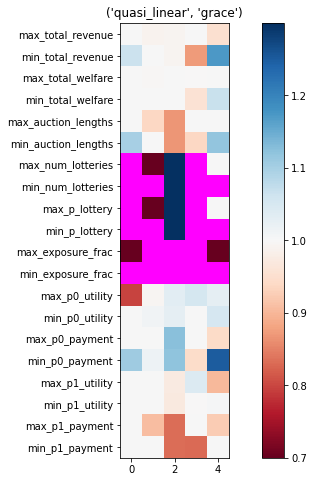

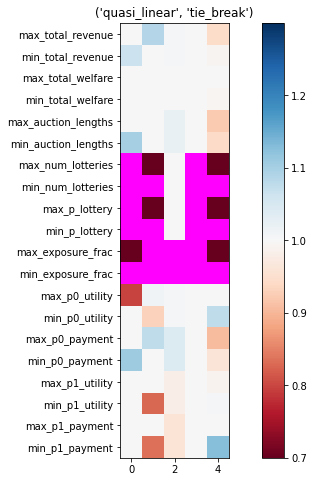

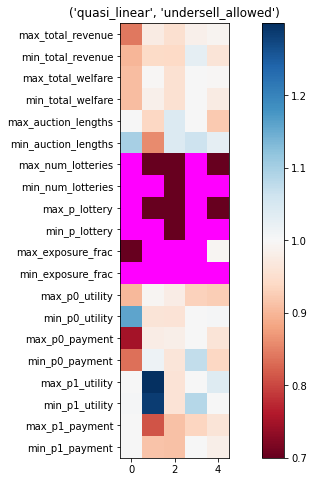

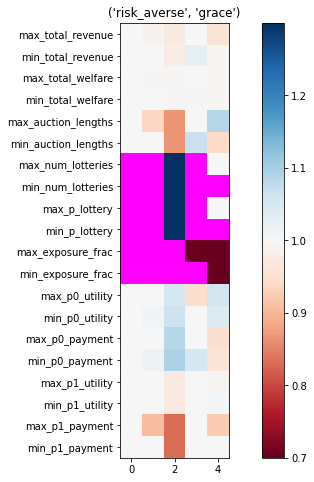

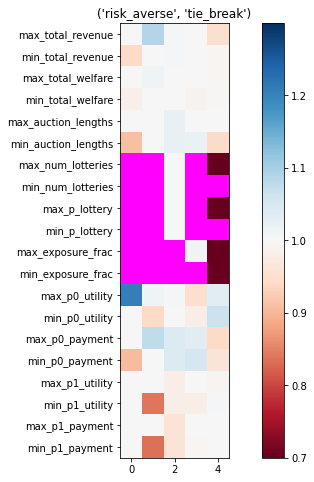

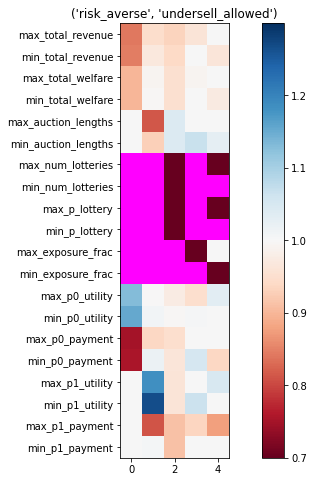

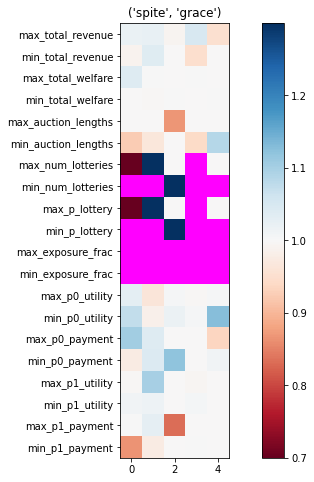

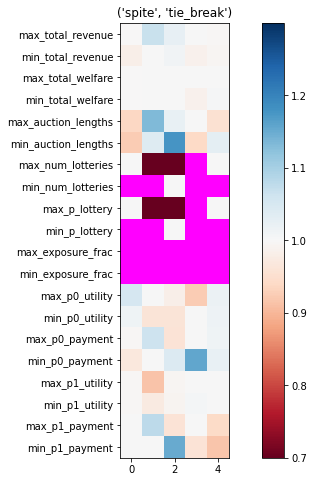

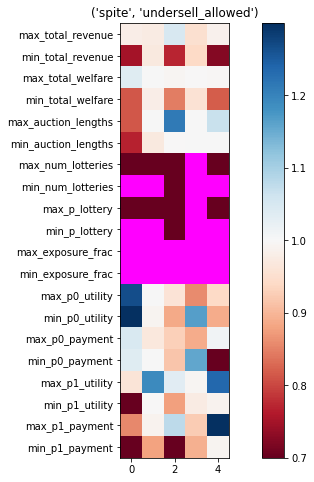

In [25]:
# 1) Get max/min for each valuation/treatment pairing over each stat

# First query down to relevant datapoints. Then groupby rule change and SATS =(game_name) and max/min?
metrics = ['total_revenue', 'total_welfare', 'auction_lengths', 'num_lotteries', 'p_lottery', 'exposure_frac']
for i in range(2): # TODO:
    metrics += [f'p{i}_utility', f'p{i}_payment']


df_plt_indexed = df_plt.set_index(['value_structure', 'rule']).sort_index().copy()

def make_data_dict(df):
    data = dict()
    for metric in metrics:
        data[f'max_{metric}'] = df.groupby('base_game_name')[metric].max()
        data[f'min_{metric}'] = df.groupby('base_game_name')[metric].min()
    return pd.DataFrame(data)
    
for idx, grp_df in df_plt.groupby(['value_structure', 'rule']):
    if idx[1] == 'base':
        continue
        
    try:
        data_grp_df = make_data_dict(grp_df)
        normalizer_grp_df = df_plt_indexed.loc[(idx[0], 'base')]
        data_normalized_df = make_data_dict(normalizer_grp_df)

        cmap_norm = plt.matplotlib.colors.TwoSlopeNorm(vmin=0.7, vcenter=1, vmax=1.3)
        cmap = plt.cm.get_cmap('RdBu').copy()
        cmap.set_bad('magenta')
        plt.figure(figsize=(12, 8))
        data = (data_grp_df / data_normalized_df).values.T
        plt.imshow(data, cmap=cmap, norm=cmap_norm)
        plt.title(idx)
        plt.yticks(range(len(data_grp_df.columns)), data_grp_df.columns)
        plt.colorbar()
        plt.show()
    except Exception as e:
        print(idx, e)

In [13]:
ATTRIBUTE = 'variant'
NORMALIZED = False
plot_type = 'scatter'
box_df = df_plt.copy()
markers = ['o', 'X', '^']

# TODO: These strings are getting unwieldy

# Vanilla for clock
CLOCK_QUERY = 'information_policy == "SHOW_DEMAND" and activity_policy == "ON" and undersell_policy == "UNDERSELL" and grace_rounds == 1 and tiebreaking_policy == "DROP_BY_PLAYER"'
# box_df = box_df.query(CLOCK_QUERY)

# # Check undersell
UNDERSELL_QUERY = 'information_policy == "SHOW_DEMAND" and activity_policy == "ON" and clock_speed == 0.3 and grace_rounds == 1'
# box_df = box_df.query(UNDERSELL_QUERY)

# # Check activity
ACTIVITY_QUERY = 'information_policy == "SHOW_DEMAND" and undersell_policy == "UNDERSELL" and clock_speed == 0.3 and grace_rounds == 1'
# box_df = box_df.query(ACACTIVITY_QUERY)

# # Check tiebreaking
TIEBREAKING_QUERY = 'information_policy == "SHOW_DEMAND" and undersell_policy == "UNDERSELL" and clock_speed == 0.3 and activity_policy == "ON" and grace_rounds == 1'
# box_df = box_df.query(TIEBREAKING_QUERY)

# Check grace
GRACE_QUERY = 'information_policy == "SHOW_DEMAND" and undersell_policy == "UNDERSELL" and clock_speed == 0.3 and activity_policy == "ON" and tiebreaking_policy == "DROP_BY_PLAYER" and not risk_aversion'
# box_df = box_df.query(GRACE_QUERY)

# Activity ON vs grace vs activity OFF
box_df = box_df.query('information_policy == "SHOW_DEMAND" and undersell_policy == "UNDERSELL" and clock_speed == 0.3 and tiebreaking_policy == "DROP_BY_PLAYER" and not risk_aversion')


box_df = box_df.sort_values(['clock_speed', 'game_name', 'config'])

# box_df = box_df.query('alg.str.contains("outcome")')

print(len(box_df))


STATS = ['total_revenue', 'total_welfare', 'auction_lengths']
# Normalize by the mean of the "base" version, so the scales line up better in the same graph
if NORMALIZED: 
    for stat in STATS:
        base = str(('SHOW_DEMAND', 0.3))
        base_stat = box_df.pivot_table(index=['base_game_name'], values=stat, aggfunc='mean', columns=ATTRIBUTE)
        box_df[f'normalized_{stat}'] = box_df.apply(lambda x: x[stat] / base_stat.loc[x['base_game_name'], base], axis=1)

for stat in STATS:
    if NORMALIZED:
        stat = f'normalized_{stat}'
    plt.figure(figsize=(20,10))
    if plot_type == 'box':
        ax = sns.boxplot(data=box_df, x='base_game_name', y=stat, hue=ATTRIBUTE)
        # ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    else:
        strip_kwargs = dict(x='base_game_name', y=stat, hue=ATTRIBUTE, s=10, alpha=0.5, dodge=True, jitter=False, palette=palette)
        sns.stripplot(data=box_df, **strip_kwargs)
        # for i, config in enumerate(box_df['config'].unique()):
        #     # print(config, markers[i])
        #     # TODO: If no entries exist, this pushes colours to the wrong positions
        #     ax = sns.stripplot(data=box_df.query(f'config == "{config}"'), marker=markers[i], **strip_kwargs)
        #     if i == 0:
        #         old_handles, old_labels = ax.get_legend_handles_labels()
        # ax.legend(old_handles, old_labels)

    plt.title(f"{stat}")

UndefinedVariableError: name 'risk_aversion' is not defined

In [54]:
evals = Evaluation.objects.filter(checkpoint__equilibrium_solver_run__name='oct4_encumberedheuristic_oct4_encumberedheuristic_3_base_undersell_allowed-cfr_port_5_extexternal_plus-101')

In [68]:
for i, e in enumerate(evals):
    if e.checkpoint.t != 16251:
        continue
    if i == 38:
        a = analyze_samples(e.samples, e.checkpoint.equilibrium_solver_run.game.load_as_spiel())
    elif i == 39:
        m = analyze_samples(e.samples, e.checkpoint.equilibrium_solver_run.game.load_as_spiel())

In [65]:
a

{'total_entropy': 0.6818788664001989,
 'unsold': array([0.00060018, 0.03741122, 0.03741122]),
 'p0_expected_exposure': -2.818056589229315,
 'p0_exposure_frac': 0.030009002700810243,
 'p0_utility': 42.85964777658323,
 'p0_payment': 45.378168746624,
 'p0_total_entropies': 0.3588025343738688,
 'p1_expected_exposure': -0.7060295462668694,
 'p1_exposure_frac': 0.0019005701710513153,
 'p1_utility': 61.718665532178534,
 'p1_payment': 69.23004647954387,
 'p1_total_entropies': 0.32307633202633007,
 'exposure_frac': 0.03180954286285886,
 'total_welfare': 219.18652853492964,
 'total_revenue': 114.60821522616786,
 'auction_lengths': 4.1412423727118135,
 'num_lotteries': 0.0,
 'p_lottery': 0.0,
 'common_allocations': [((0, 1, 1), 5035),
  ((0, 0, 0), 2494),
  ((1, 0, 0), 2468)]}

In [69]:
m

{'total_entropy': 0.0,
 'unsold': array([0., 0., 0.]),
 'p0_expected_exposure': nan,
 'p0_exposure_frac': 0.0,
 'p0_utility': 41.75315863172633,
 'p0_payment': 46.66612522504502,
 'p0_total_entropies': 0.0,
 'p1_expected_exposure': nan,
 'p1_exposure_frac': 0.0,
 'p1_utility': 61.88452174914982,
 'p1_payment': 70.68399195359072,
 'p1_total_entropies': 0.0,
 'exposure_frac': 0.0,
 'total_welfare': 220.9877975595119,
 'total_revenue': 117.35011717863571,
 'auction_lengths': 4.247949589917984,
 'num_lotteries': 0.0,
 'p_lottery': 0.0,
 'common_allocations': [((0, 1, 1), 5019),
  ((0, 0, 0), 2504),
  ((1, 0, 0), 2475)]}

In [73]:
run = EquilibriumSolverRun.objects.get(name='oct4_encumberedheuristic_oct4_encumberedheuristic_3_spite_undersell_allowed-cfr_port_5_extexternal_plus-103', experiment__name='oct04_external_heuristics_v8')

In [76]:
game, final_checkpoint, policy = get_results(run, load_policy=True)
evaluation = final_checkpoint.get_modal_eval()


In [77]:
retval = nash_conv(game, policy, return_only_nash_conv=False, restrict_to_heuristics=True)

In [78]:
retval

_NashConvReturn(nash_conv=4.6445469592915885, player_improvements=array([3.0875097 , 1.55703726]), br_policies=[<open_spiel.python.algorithms.best_response.BestResponsePolicy object at 0x7efdba27ea90>, <open_spiel.python.algorithms.best_response.BestResponsePolicy object at 0x7efde799cd00>])

In [81]:
env_and_policy = make_env_and_policy(game, dict(final_checkpoint.equilibrium_solver_run.config))
for agent in env_and_policy.agents:
    agent.policy = policy
for player in range(game.num_players()):
    env_and_policy.agents[player] = ModalAgentDecorator(env_and_policy.agents[player])
modal_retval = nash_conv(game, env_and_policy.make_policy(), return_only_nash_conv=False, restrict_to_heuristics=True)
modal_retval

_NashConvReturn(nash_conv=14.984234330169471, player_improvements=array([11.5860396 ,  3.39819474]), br_policies=[<open_spiel.python.algorithms.best_response.BestResponsePolicy object at 0x7efd85919250>, <open_spiel.python.algorithms.best_response.BestResponsePolicy object at 0x7efd859198e0>])

In [ ]:
env_and_policy = make_env_and_policy(game, dict(final_checkpoint.equilibrium_solver_run.config))
for agent in env_and_policy.agents:
    agent.policy = policy
for player in range(game.num_players()):
    env_and_policy.agents[player] = ModalAgentDecorator(env_and_policy.agents[player])
modal_retval = nash_conv(game, env_and_policy.make_policy(), return_only_nash_conv=False, restrict_to_heuristics=True)
modal_retval